## Curiosity Driven RL Model
Paper: https://arxiv.org/abs/1808.04355

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import random

## Experience Buffer

In [2]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

## Environment
Mountain Car: use the least number of timestep to get the car out of a hill.
The lower the 'steps', the greater the reward. Hence, below the statistic used is the number of steps. We should expect the nubmer of steps to go down as training goes on.

In [3]:
env = gym.make('MountainCar-v0')
env = env.unwrapped

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/u20842/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Hyperparameters

In [4]:
batch_size=128
lr=0.01
gamma=0.98
epsilon=0.95
replace_target_iter=300

env.action_space.n = 3
env.observation_space.n = 2

## Model

A simple DQN with a 'intrinsic reward' model.
The intrinsic reward model calcualates an intrinsic reward, which is added to self.r as the total reward for training.

In short, the intrinsic reward model predicts the next state given current state and action. This is to encourage the agent to explore options that reduces uncertainty.

In [5]:
class CuriosityNet:
    def __init__(self):

        self.s = tf.placeholder(tf.float32, [None, env.observation_space.n])  
        self.a = tf.placeholder(tf.int32, [None, ])         
        self.r = tf.placeholder(tf.float32, [None, ])        
        self.s1 = tf.placeholder(tf.float32, [None, env.observation_space.n]) 

        # intrinsic reward
        with tf.variable_scope('intrinsic'):
            sa = tf.concat((self.s, tf.expand_dims(tf.cast(self.a, dtype=tf.float32), axis=1)), axis=1)

            sa_dense = tf.layers.dense(sa, 32, activation=tf.nn.relu)
            pred_s1 = tf.layers.dense(sa_dense, env.observation_space.n) 
        
        self.int_r = tf.reduce_sum(tf.square(self.s1 - pred_s1), axis=1) 

        self.int_train = tf.train.RMSPropOptimizer(lr).minimize(self.int_r)
        
        # simple DQN
        total_reward = self.r + self.int_r
        
        with tf.variable_scope('main'):
            e1 = tf.layers.dense(self.s, 128, tf.nn.relu)
            self.q = tf.layers.dense(e1, env.action_space.n)
            
        with tf.variable_scope('target'):
            t1 = tf.layers.dense(self.s1, 128, tf.nn.relu)
            q_ = tf.layers.dense(t1, env.action_space.n)

        q_target = total_reward + gamma * tf.reduce_max(q_, axis=1)
        
        a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
        q_wrt_a = tf.gather_nd(params=self.q, indices=a_indices)

        dqn_loss = tf.losses.mean_squared_error(labels=q_target, predictions=q_wrt_a)
        self.dqn_train = tf.train.RMSPropOptimizer(lr).minimize(
            dqn_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'main'))
        
        # Updating target with main
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target')
        m_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='main')
        self.target_replace_op = [tf.assign(t, m) for t, m in zip(t_params, m_params)]

        self.sess = tf.Session()

        self.sess.run(tf.global_variables_initializer())

In [6]:
tf.reset_default_graph()

dqn = CuriosityNet()
jList = []
myBuffer = experience_buffer()
total_step = 0

for epi in range(200):
    s = env.reset()
    j = 0
    while True:
        if np.random.uniform() < epsilon:
            actions_value = dqn.sess.run(dqn.q, feed_dict={dqn.s: [s]})
            a = np.argmax(actions_value)
        else:
            a = np.random.randint(0, env.action_space.n)
    
        s1, r, done, info = env.step(a)
        
        experience = np.expand_dims(np.array([s, a, r, s1, done]), 0)
        myBuffer.add(experience)  

        if total_step % replace_target_iter == 0:
            dqn.sess.run(dqn.target_replace_op)

        batch = myBuffer.sample(min(batch_size, len(myBuffer.buffer)))
        bs = np.vstack(batch[:, 0])
        ba = batch[:, 1]
        br = batch[:, 2]
        bs1 = np.vstack(batch[:, 3])

        dqn.sess.run(dqn.dqn_train, feed_dict={dqn.s: bs, dqn.a: ba, dqn.r: br, dqn.s1: bs1})
        if total_step % 1000 == 0:     
            dqn.sess.run(dqn.int_train, feed_dict={dqn.s: bs, dqn.a: ba, dqn.s1: bs1})
            
        total_step += 1
        
        if done:
            print('Episode:', epi, ":", j, "steps")
            jList.append(j)
            break
        s = s1
        j += 1


Episode: 0 : 16551 steps
Episode: 1 : 1473 steps
Episode: 2 : 563 steps
Episode: 3 : 872 steps
Episode: 4 : 390 steps
Episode: 5 : 611 steps
Episode: 6 : 236 steps
Episode: 7 : 406 steps
Episode: 8 : 547 steps
Episode: 9 : 315 steps
Episode: 10 : 414 steps
Episode: 11 : 372 steps
Episode: 12 : 310 steps
Episode: 13 : 463 steps
Episode: 14 : 357 steps
Episode: 15 : 425 steps
Episode: 16 : 175 steps
Episode: 17 : 475 steps
Episode: 18 : 373 steps
Episode: 19 : 255 steps
Episode: 20 : 410 steps
Episode: 21 : 239 steps
Episode: 22 : 398 steps
Episode: 23 : 173 steps
Episode: 24 : 163 steps
Episode: 25 : 234 steps
Episode: 26 : 244 steps
Episode: 27 : 217 steps
Episode: 28 : 224 steps
Episode: 29 : 150 steps
Episode: 30 : 156 steps
Episode: 31 : 174 steps
Episode: 32 : 187 steps
Episode: 33 : 155 steps
Episode: 34 : 156 steps
Episode: 35 : 149 steps
Episode: 36 : 201 steps
Episode: 37 : 154 steps
Episode: 38 : 144 steps
Episode: 39 : 244 steps
Episode: 40 : 229 steps
Episode: 41 : 156 steps

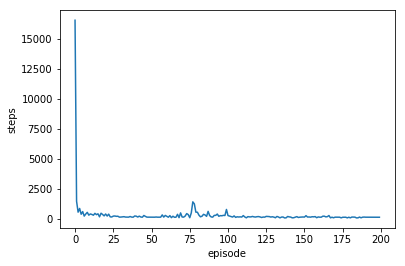

In [7]:
plt.plot(jList)
plt.ylabel("steps")
plt.xlabel("episode")
plt.show()